# Gradient descent

Gradient descent (GD) is an iterative optimization algorithm used to find the minimum of a function. It's widely used in machine learning and deep learning for training models by minimizing a loss function.

In [1]:
%matplotlib inline
from typing import Callable, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from matplotlib import cm

sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle':'--'})

## Linear regression example

Let's apply GD to the previously studied linear regression problem, where the loss function is the sum of squared error.

We will use GD to find the values of intercept and slope that minimize the loss function.

In [2]:
auto = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/auto_mpg.csv")
# drop the null values
auto.dropna(inplace=True)
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


First let's get the "correct" answer of the intercept and slope.

In [3]:
# simple linear regression with the `statsmodels` library
auto_model = smf.ols(formula='mpg ~ horsepower', data=auto)
auto_result = auto_model.fit()
print(auto_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           7.03e-81
Time:                        21:10:04   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.0

Let's define the loss function, which takes the dependent variables, independent variables, and the model parameters (intercpet and slope) as inputs.

In [4]:
def linear_regression_loss(
    X: np.ndarray,
    y: np.ndarray,
    betas: np.ndarray,
    normalized: bool = False,
) -> float:
    """Calculates the loss of a linear regression problem.
    
    Args:
        X: The array (matrix) that contains the independent variables. By convention, the shape is n by (d+1).
        y: The array (column vector) that contains the depedent variable. The shape is n by 1.
        betas: The array that contains the coefficients. The shape is (d+1) by 1.
        normalized: If True, the loss function is normalized by sample sizes (i.e., n). Default value: False.
    
    Returns:
        (float): The loss function value.
        
    Raises:
        AssertionError: If the shape of the predicted value is different from y.
    """
    if not isinstance(betas, np.ndarray):
        betas = np.array(betas).reshape(-1, 1)
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    
    y_pred = X @ betas
    assert y.shape == y_pred.shape, f"y has shape of {y.shape} and y_pred of {y_pred.shape}"
    loss = np.sum(np.square(y - X @ betas))
    
    if normalized:
        loss /= len(y)
    
    return loss

In [5]:
X_auto = np.vstack((np.ones(shape=len(auto)), auto["horsepower"].values.T)).T
y_auto = auto["mpg"].values

# test run
auto_betas = [50, -0.2]
linear_regression_loss(X=X_auto, y=y_auto, betas=auto_betas)

22974.22

Next we will visualize the loss function, by fixing the slope, but only varying the value of intercept. We should see the loss function follows a parabola shape.

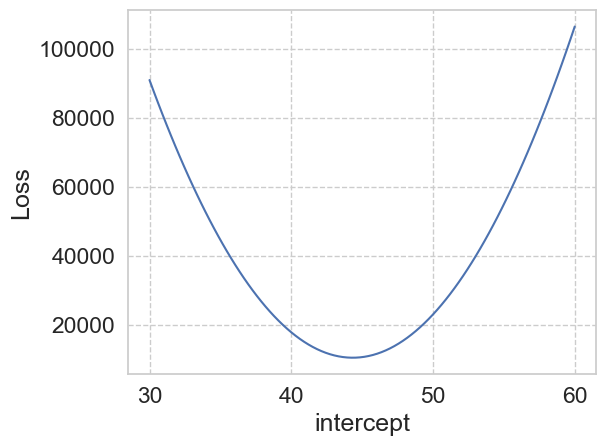

In [6]:
# fix beta_1, i.e., slope
auto_slope = -0.2
auto_losses = []
auto_beta_0s = np.linspace(start=30, stop=60, num=100)
for b in auto_beta_0s:
    auto_betas = np.array([b, auto_slope]).reshape(-1, 1)
    loss = linear_regression_loss(X=X_auto, y=y_auto, betas=auto_betas)
    auto_losses.append(loss)
    
# plot the loss function
plt.figure()
sns.lineplot(x=auto_beta_0s, y=auto_losses)
plt.xlabel("intercept")
plt.ylabel("Loss")
plt.tight_layout()

We will define the gradient of the loss function, which also takes the dependent variables, independent variables, and the model parameters (intercpet and slope) as inputs.

In [7]:
def linear_regression_loss_gradient(
    X: np.ndarray,
    y: np.ndarray,
    betas: np.ndarray,
    normalized: bool = False,
) -> np.ndarray:
    """Calculates the gradient of the loss of a linear regression problem.
    
    Args:
        X: The array (matrix) that contains the independent variables. By convention, the shape is n by (d+1).
        y: The array (column vector) that contains the depedent variable. The shape is n by 1.
        betas: The array that contains the coefficients. The shape is (d+1) by 1.
        normalized: If True, the gradient is normalized by sample sizes (i.e., n). Default value: False.
    
    Returns:
        (float): The value of the gradient.
    """
    if not isinstance(betas, np.ndarray):
        betas = np.array(betas).reshape(-1, 1)
    if y.ndim == 1:
        y = y.reshape(-1, 1)
        
    grad = -2 * (X.T @ (y - X @ betas))
    assert grad.shape == betas.shape, f"The shape of grad is {grad.shape} and betas is {betas.shape}"
    if normalized:
        grad /= len(y)
    
    return grad

Finally, let's construct the GD routine, by using the previously defined loss function, and the gradient function.

In [8]:
def gradient_descent(
    X: np.ndarray,
    y: np.ndarray,
    initial_guess: Union[List, np.ndarray], 
    learning_rate: float,
    loss_function: Callable,
    gradient_function: Callable,
    verbose: bool = False,
    threshold: float = 1e-6,
    fix_guess: Dict = None,
) -> Tuple[List, List]:
    """Gradient descent routine.
    
    Args:
        X: The input data without labels.
        y: The labels.
        initial_guess: The starting point of the gradient descent. 
        learning_rate: The learning rate of the gradient descent.
        loss_function: Provided loss function, that takes (X, y, parameter) as inputs.
        gradient_function: Provided gradient of the loss function, that takes (X, y, parameter) as inputs.
        verbose: If set to True, print out intermediate results.
        threshold: Absolute value of different in loss, below which is considered converged.
        fix_guess: A dictionay to fix given dimension(s) of the parameter.
        
    Return:
        List: The history of parameters.
        List: The history of the losses.
    """
    guess_current = np.array(initial_guess).reshape(-1, 1)
    if fix_guess:
        for k, v in fix_guess.items():
            guess_current[k] = v
            
    guess_iter = [guess_current]
    losses_iter = [loss_function(X=X, y=y, betas=guess_current)]

    difference = float("inf")
    iteration_count = 0
    while abs(difference) > threshold:
        iteration_count += 1
        guess_next = guess_current - learning_rate * gradient_function(
            X=X, y=y, betas=guess_current) 
        if fix_guess:
            for k, v in fix_guess.items():
                guess_next[k] = v
        guess_iter.append(guess_next)
        
        losses_next = loss_function(X=X, y=y, betas=guess_next)
        difference = losses_next - losses_iter[-1]
        losses_iter.append(losses_next)
        
        # update guess
        guess_current = guess_next
        # to print out intermediate results
        if verbose and iteration_count % 1000 == 0:
            print(guess_next, losses_next)
    
    # some datatype processing
    guess_iter: List[List[float]] = list(map(lambda x: list(x.flatten()), guess_iter))
    return guess_iter, losses_iter

In [9]:
auto_guess_iter, auto_losses_iter = gradient_descent(
    X=X_auto,
    y=y_auto,
    initial_guess=[60, -0.2], 
    learning_rate=1e-4,
    loss_function=linear_regression_loss,
    gradient_function=linear_regression_loss_gradient,
    verbose=True,
    threshold=1e-3,
    fix_guess={1: -0.2}
)

print("The final values are:")
print(auto_guess_iter[-1])

The final values are:
[44.34358146811218, -0.2]


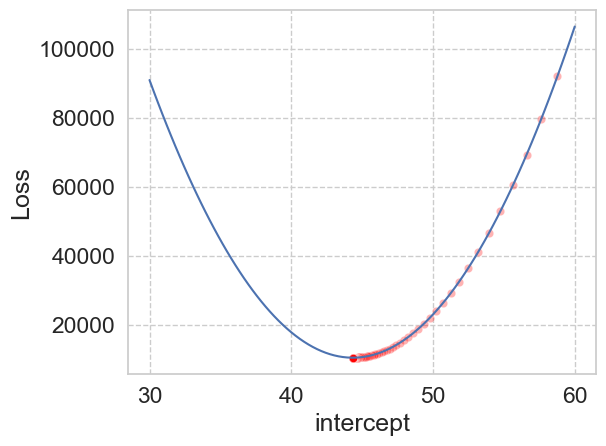

In [10]:
# plot the loss function
plt.figure()
sns.lineplot(x=auto_beta_0s, y=auto_losses)

# plot the iterative updates
sns.scatterplot(
    x=np.array(auto_guess_iter)[1:, 0], y=auto_losses_iter[1:], color="red", alpha=0.3)

plt.xlabel("intercept")
plt.ylabel("Loss")
plt.tight_layout()

In the previous example, we fixed the slope and only vary the intercept. Now let's vay both of them, as it is the "real case".

The minimum loss is 9385.926


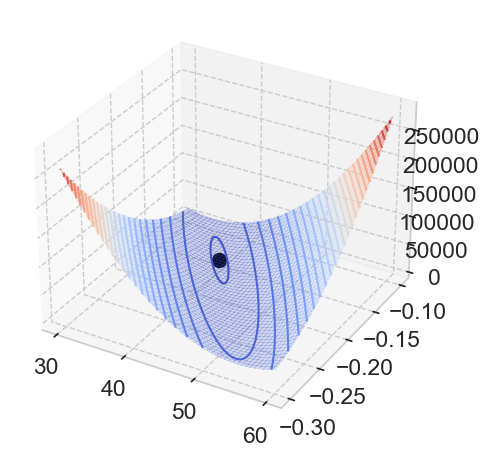

In [11]:
# Plot the loss function with minimal
auto_beta_1s = np.linspace(start=-0.3, stop=-0.1, num=100)
auto_X, auto_Y = np.meshgrid(auto_beta_0s, auto_beta_1s)
auto_losses_2d = np.zeros(shape=auto_X.shape)  # initialize the losses
for i, x in enumerate(auto_X):
    for j in range(len(x)):
        auto_losses_2d[i][j] = linear_regression_loss(
            X=X_auto, y=y_auto, betas=[auto_X[i][j], auto_Y[i][j]])
        
# make the 3d plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# plot the actual minimum
auto_betas_min = [39.9359, -0.1578]  # Assume this is known
auto_loss_min = linear_regression_loss(X=X_auto, y=y_auto, betas=auto_betas_min)
print(f"The minimum loss is {auto_loss_min:5.3f}")
ax.scatter(
    xs=[auto_betas_min[0],], 
    ys=[auto_betas_min[1],], 
    zs=[auto_loss_min],
    s=100,
    color="black",
)
# plot the loss function
surf = ax.plot_surface(auto_X, auto_Y, auto_losses_2d, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)
plt.contour(auto_X, auto_Y, auto_losses_2d, levels=30, cmap=cm.coolwarm)
plt.tight_layout()

In [12]:
%%time
# gradient descent with both intercept and slope
# witht he following setting, it can take a few seconds to converge
auto_guess_iter, auto_losses_iter = gradient_descent(
    X=X_auto,
    y=y_auto,
    initial_guess=[50, -0.1], 
    learning_rate=2e-7,
    loss_function=linear_regression_loss,
    gradient_function=linear_regression_loss_gradient,
    threshold=1e-5,
)

print("The final values are:")
print(auto_guess_iter[-1])

The final values are:
[40.01148996455557, -0.1584823393221802]
CPU times: user 2.94 s, sys: 556 ms, total: 3.5 s
Wall time: 2.58 s


/var/folders/ck/6xgx96j15vd6tcwzl68twbpc0000gn/T/ipykernel_5359/2600610578.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(


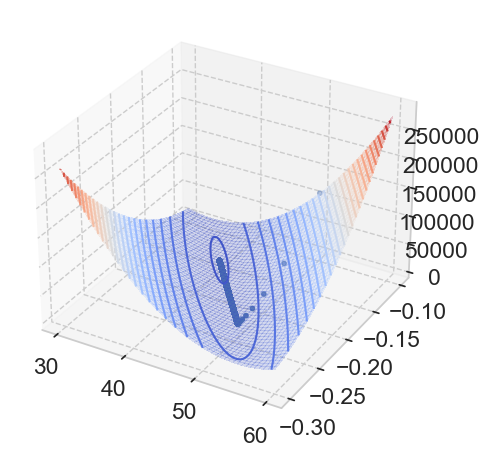

In [13]:
# make the 3d plot with the gradient descent path
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# plot the loss function
surf = ax.plot_surface(auto_X, auto_Y, auto_losses_2d, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)
plt.contour(auto_X, auto_Y, auto_losses_2d, levels=30, cmap=cm.coolwarm)

# plot the path
sample_rate = 10
ax.scatter3D(
    xs=np.array(auto_guess_iter)[:, 0][::sample_rate], 
    ys=np.array(auto_guess_iter)[:, 1][::sample_rate], 
    zs=auto_losses_iter[::sample_rate],
    s=10,
    cmap=cm.coolwarm,
)
plt.tight_layout()

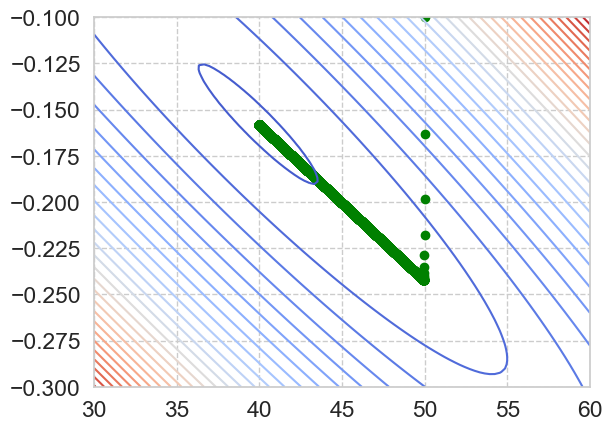

In [14]:
# contour plot of the same path
plt.figure()
plt.contour(auto_X, auto_Y, auto_losses_2d, levels=30, cmap=cm.coolwarm)
plt.scatter(
    x=np.array(auto_guess_iter)[:, 0][::sample_rate],
    y=np.array(auto_guess_iter)[:, 1][::sample_rate],
    color="green",
)
plt.show()

## Logistic regression example

Here let's apply GD to the logistic regression case where the loss function is the cross-entropy, and there is no closed-form solution for the minimum.

The steps will be very similar to the linear regression case: we first need to define the loss function, and the gradient, then we will apply the GD routine.

In [15]:
cancer = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/breast_cancer.csv")
cancer_label = cancer["diagnosis"].apply(lambda x: 0 if x == "B" else 1)
cancer.insert(2, "label", cancer_label)
cancer.head()

,id,diagnosis,label,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,...,radius_extreme,texture_extreme,perimeter_extreme,area_extreme,smoothness_extreme,compactness_extreme,concavity_extreme,concave_extreme,symmetry_extreme,fractal_extreme
0,842302,M,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


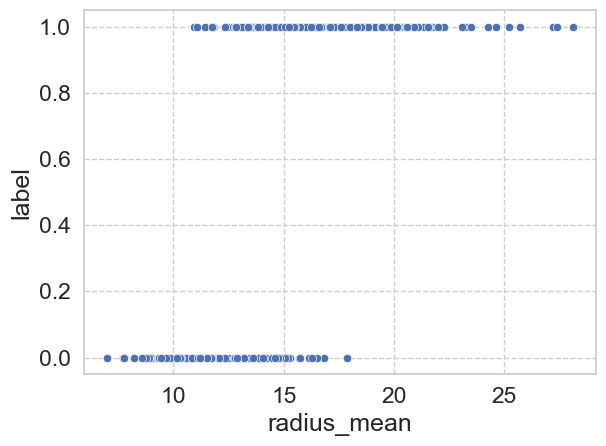

In [16]:
plt.figure()
sns.scatterplot(x="radius_mean", y="label", data=cancer)
plt.tight_layout()

In [17]:
# simple logistic regression with the `statsmodels` library
cancer_model = smf.logit(formula='label ~ radius_mean', data=cancer)
cancer_result = cancer_model.fit()
print(cancer_result.summary())

Optimization terminated successfully.
         Current function value: 0.289992
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                  569
Model:                          Logit   Df Residuals:                      567
Method:                           MLE   Df Model:                            1
Date:                Sun, 08 Oct 2023   Pseudo R-squ.:                  0.5608
Time:                        21:10:09   Log-Likelihood:                -165.01
converged:                       True   LL-Null:                       -375.72
Covariance Type:            nonrobust   LLR p-value:                 1.192e-93
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -15.2459      1.325    -11.509      0.000     -17.842     -12.649
radius_mean     1.0336    

In [18]:
X_cancer = np.vstack((np.ones(shape=len(cancer)), cancer["radius_mean"].values.T)).T
y_cancer = cancer["label"].values

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logistic_regression_loss(
    X: np.ndarray,
    y: np.ndarray,
    betas: np.ndarray,
    normalized: bool = False,
) -> float:
    """Calculates the loss of a logistic regression problem, i.e., cross entropy."""
    if not isinstance(betas, np.ndarray):
        betas = np.array(betas).reshape(-1, 1)
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    
    y_pred = X @ betas
    assert y.shape == y_pred.shape, f"y has shape of {y.shape} and y_pred of {y_pred.shape}"
    
    # We add a small positive number inside `log()` to avoid log(0)
    loss = np.sum(y * np.log(1e-10 + sigmoid(X @ betas)) + (1 - y) * np.log(1e-10 + 1 - sigmoid(X @ betas)))
    if normalized:
        loss /= len(y)
        
    return -1. * loss

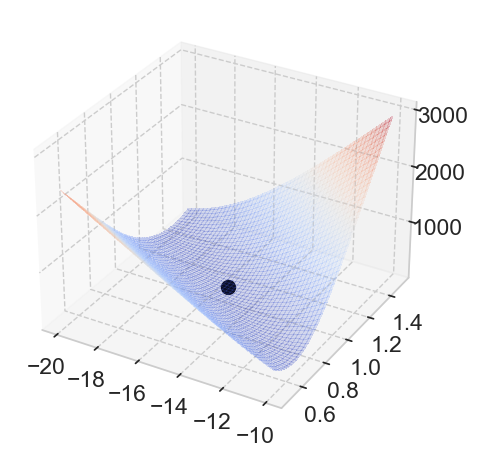

In [20]:
# Plot the loss function with minimal
cancer_beta_0s = np.linspace(start=-20, stop=-10, num=100)
cancer_beta_1s = np.linspace(start=0.5, stop=1.5, num=100)
cancer_X, cancer_Y = np.meshgrid(cancer_beta_0s, cancer_beta_1s)
cancer_losses_2d = np.zeros(shape=cancer_X.shape)  # initialize the losses
for i, x in enumerate(cancer_X):
    for j in range(len(x)):
        cancer_losses_2d[i][j] = logistic_regression_loss(
            X=X_cancer, y=y_cancer, betas=[cancer_X[i][j], cancer_Y[i][j]])
        
# make the 3d plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# plot the actual minimum
cancer_betas_min = [-15.2459, 1.0336]
ax.scatter(
    xs=[cancer_betas_min[0],], 
    ys=[cancer_betas_min[1],], 
    zs=[logistic_regression_loss(X=X_cancer, y=y_cancer, betas=cancer_betas_min)],
    s=100,
    color="black",
)
# plot the loss function
surf = ax.plot_surface(cancer_X, cancer_Y, cancer_losses_2d, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)

plt.tight_layout()

In [21]:
def logistic_regression_loss_gradient(
    X: np.ndarray,
    y: np.ndarray,
    betas: np.ndarray,
    normalized: bool = False,
) -> float:
    """Calculate the loss of a logistic regression problem, i.e., cross entropy."""
    if not isinstance(betas, np.ndarray):
        betas = np.array(betas).reshape(-1, 1)
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    
    grad = -1. * (X.T @ (y - sigmoid(X @ betas)))
    assert grad.shape == betas.shape, f"The shape of grad is {grad.shape} and betas is {betas.shape}"
    if normalized:
        grad /= len(y)
    
    return grad

In [22]:
%%time
# gradient descent for logistic regression
cancer_guess_iter, cancer_losses_iter = gradient_descent(
    X=X_cancer,
    y=y_cancer,
    initial_guess=[-20, 0.6], 
    learning_rate=1e-4,
    loss_function=logistic_regression_loss,
    gradient_function=logistic_regression_loss_gradient,
    threshold=1e-7,
)

print("The final values are:")
print(cancer_guess_iter[-1])

The final values are:
[-15.301752200029057, 1.0374949359153787]
CPU times: user 3.22 s, sys: 236 ms, total: 3.45 s
Wall time: 2.73 s


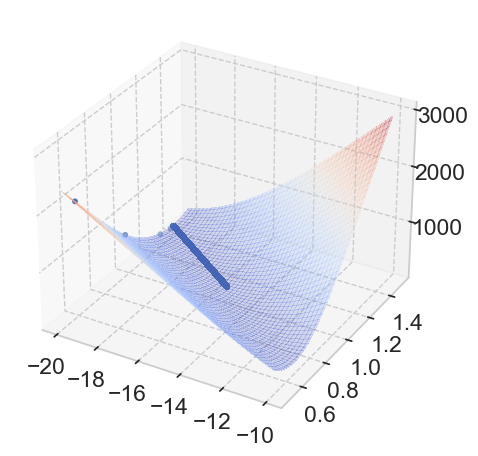

In [23]:
# make the 3d plot with the gradient descent path
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# plot the loss function
surf = ax.plot_surface(cancer_X, cancer_Y, cancer_losses_2d, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.2)

# plot the path
sample_rate = 1
ax.scatter3D(
    xs=np.array(cancer_guess_iter)[:, 0][::sample_rate], 
    ys=np.array(cancer_guess_iter)[:, 1][::sample_rate], 
    zs=cancer_losses_iter[::sample_rate],
    s=10,
)
plt.tight_layout()
plt.show()

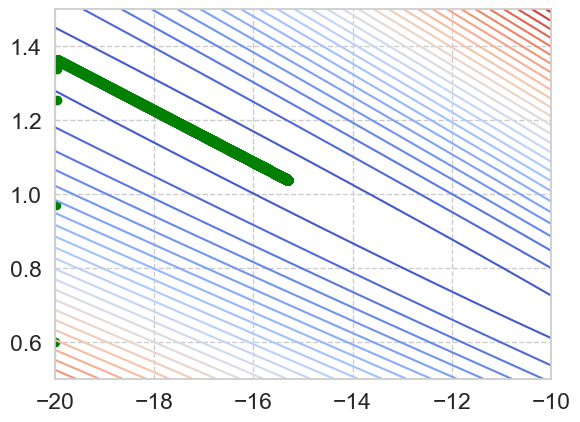

In [24]:
# contour plot of the same path
plt.figure()
plt.contour(cancer_X, cancer_Y, cancer_losses_2d, levels=30, cmap=cm.coolwarm)
plt.scatter(
    x=np.array(cancer_guess_iter)[:, 0][::sample_rate], 
    y=np.array(cancer_guess_iter)[:, 1][::sample_rate],
    color="green",
)
plt.show()

[-15.3017522    1.03749494]


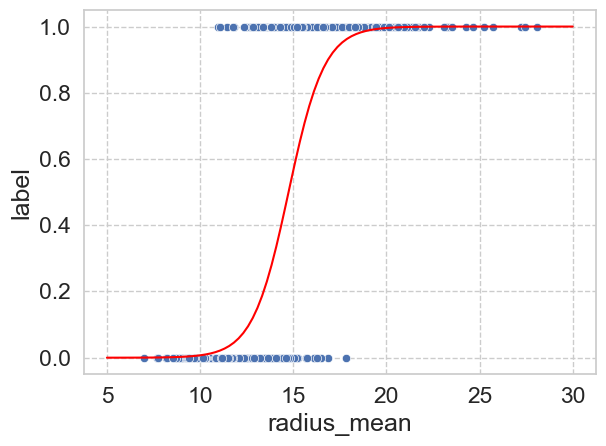

In [25]:
# plot the fitted curve
cancer_betas_fitted = np.array(cancer_guess_iter[-1])
print(cancer_betas_fitted)

plt.figure()
sns.scatterplot(x="radius_mean", y="label", data=cancer)
x = np.linspace(start=5, stop=30, num=100)
X = np.vstack((np.ones(shape=len(x)), x.T)).T
y = sigmoid(X @ cancer_betas_fitted)
sns.lineplot(x=x, y=y, color="red")
plt.tight_layout()